<a href="https://colab.research.google.com/github/uzayri001/BookRecommendation/blob/main/BookRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2025-04-04 09:23:32--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  95.7MB/s    in 0.3s    

2025-04-04 09:23:32 (95.7 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [3]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [6]:
print(df_books.head())
print(df_ratings.head())

         isbn                                              title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

                 author  
0    Mark P. O. Morford  
1  Richard Bruce Wright  
2          Carlo D'Este  
3      Gina Bari Kolata  
4       E. J. W. Barber  
     user        isbn  rating
0  276725  034545104X     0.0
1  276726  0155061224     5.0
2  276727  0446520802     0.0
3  276729  052165615X     3.0
4  276729  0521795028     6.0


In [7]:
# filter out users with less than 200 ratings
df_ratings_filtered = df_ratings.groupby('user').filter(lambda x: len(x) >= 200)

# filter out books with less than 100 ratings
df_ratings_filtered = df_ratings_filtered.groupby('isbn').filter(lambda x: len(x) >= 100)

print(df_books.head())
print(df_ratings.head())

         isbn                                              title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

                 author  
0    Mark P. O. Morford  
1  Richard Bruce Wright  
2          Carlo D'Este  
3      Gina Bari Kolata  
4       E. J. W. Barber  
     user        isbn  rating
0  276725  034545104X     0.0
1  276726  0155061224     5.0
2  276727  0446520802     0.0
3  276729  052165615X     3.0
4  276729  0521795028     6.0


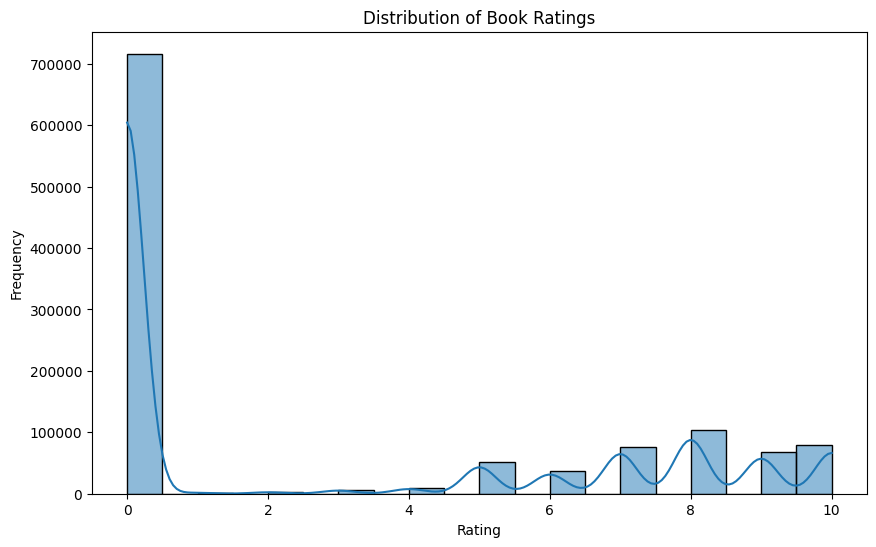

In [9]:
# Plot the distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(df_ratings['rating'], bins=20, kde=True)
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

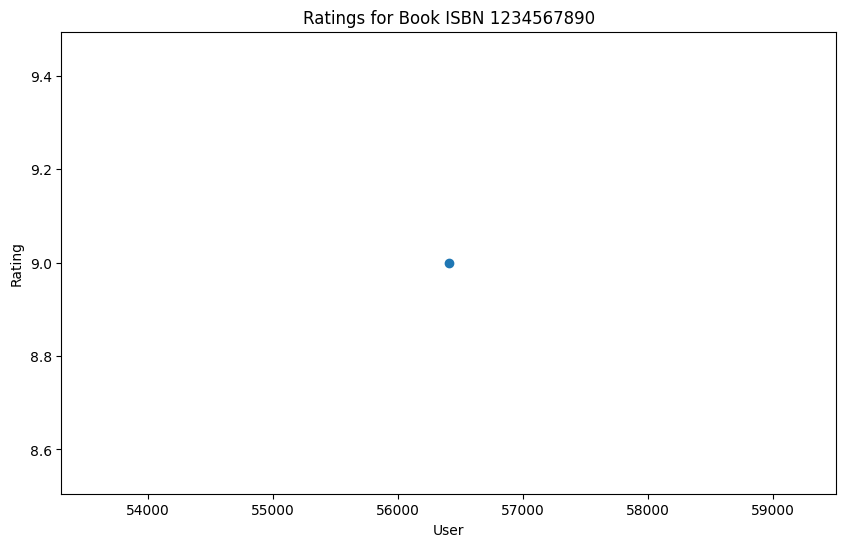

In [10]:
# Filter ratings for a specific book (example ISBN: '1234567890')
specific_book = df_ratings[df_ratings['isbn'] == '1234567890']

plt.figure(figsize=(10, 6))
plt.scatter(specific_book['user'], specific_book['rating'])
plt.title('Ratings for Book ISBN 1234567890')
plt.xlabel('User')
plt.ylabel('Rating')
plt.show()

In [15]:
rating_matrix = df_ratings_filtered.pivot(index='isbn', columns='user', values='rating')
filled_rating_matrix = rating_matrix.fillna(0)

In [16]:
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(filled_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [19]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  recommended_books = []
  queryBook = df_books[df_books['title'].str.lower() == book.lower()]
  queryBookISBN = queryBook['isbn'].values[0]
  query_index = filled_rating_matrix.index.get_loc(queryBookISBN)
  distances, indices = model.kneighbors(filled_rating_matrix.iloc[[query_index]], n_neighbors=6)
  for i in range(1, 6):  # Skip the first result as it is the queried book itself
        recommended_isbn = filled_rating_matrix.index[indices[0][i]]
        recommended_title = df_books[df_books['isbn'] == recommended_isbn]['title'].values[0]
        recommended_books.append([recommended_title, distances[0][i]])
  return [book, recommended_books]

In [20]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [['The Lovely Bones: A Novel', np.float32(0.7234864)], ["The Pilot's Wife : A Novel", np.float32(0.8192678)], ['The Joy Luck Club', np.float32(0.81986046)], ['The Notebook', np.float32(0.8236683)], ['Bel Canto: A Novel', np.float32(0.8247875)]]]
You haven't passed yet. Keep trying!
